In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2024/sample_submission.json
/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json


In [2]:
import json

def load_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

#load the data
training_solutions = load_json('/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json')
evaluation_solutions = load_json('/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json')
training_challenges = load_json('/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json')
evaluation_challenges = load_json('/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json')
test_challenges = load_json('/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json')
sample_submission = load_json('/kaggle/input/arc-prize-2024/sample_submission.json')

In [3]:
def inspect_data(data, num_samples=1):
    for key, value in list(data.items())[:num_samples]:
        print(f"Key: {key}")
        print(f"Sample Data: {value}\n")
        
print("Training Solutions:")
inspect_data(training_solutions)

print("Training Challenges:")
inspect_data(training_challenges)

print("Evaluation Solutions:")
inspect_data(evaluation_solutions)

print("Evaluation Challenges:")
inspect_data(evaluation_challenges)

print("Test Challenges:")
inspect_data(test_challenges)

print("Sample submission:")
inspect_data(sample_submission)

Training Solutions:
Key: 007bbfb7
Sample Data: [[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 7, 0, 7, 7, 0, 0, 0, 0]]]

Training Challenges:
Key: 007bbfb7
Sample Data: {'test': [{'input': [[7, 0, 7], [7, 0, 7], [7, 7, 0]]}], 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]], 'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7]]}, {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]], 'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4, 0, 4, 0, 0,

In [4]:
sample_key = list(training_solutions.keys())[0]
print(f"Sample Key: {sample_key}")
print("Sample Data:", training_solutions[sample_key])

Sample Key: 007bbfb7
Sample Data: [[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 7, 0, 7, 7, 0, 0, 0, 0]]]


In [5]:
#compute the mean, standard deviation, minimum, and maximum values of the data
sample_data = training_solutions[sample_key]
#convert to numpy array
data_array = np.array(sample_data)

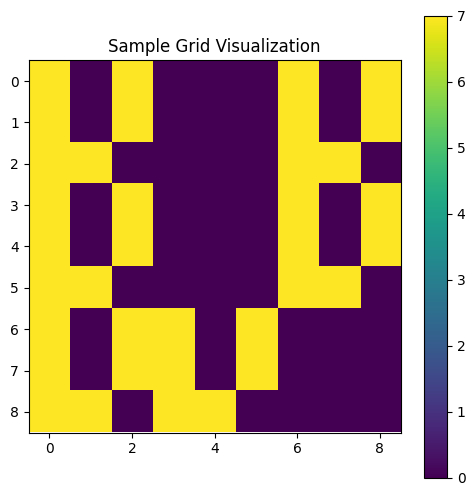

Grid Summary:
Mean Value: 3.11
Standard Deviation: 3.48
Minimum Value: 0
Maximum Value: 7

Frequency Distribution:
Value 0: 45 occurrences
Value 7: 36 occurrences


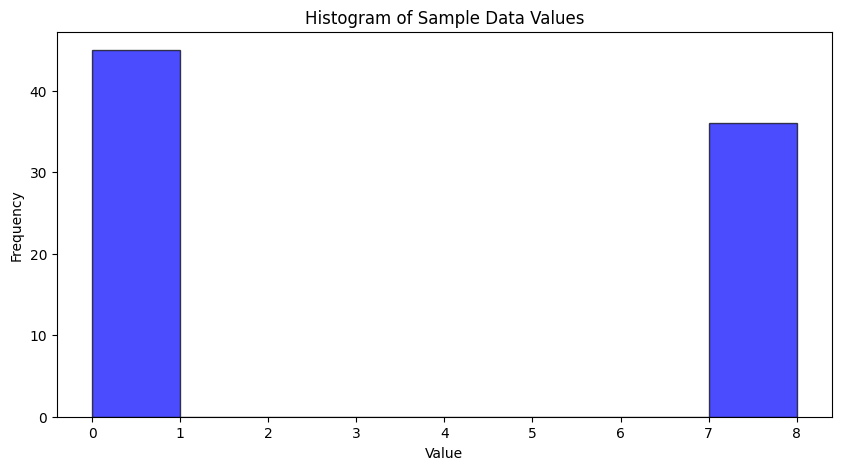

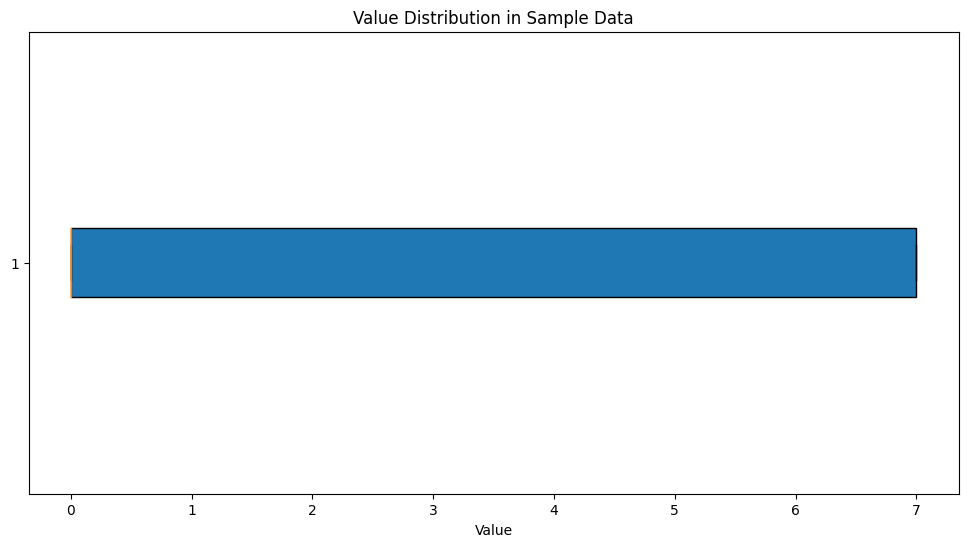

Histogram Summary:
Mean Value: 3.11
Median Value: 0.00
Minimum Value: 0
Maximum Value: 7

Frequency Distribution:
Value 0: 45 occurrences
Value 7: 36 occurrences
Boxplot Summary:
Median Value: 0.00
1st Quartile (Q1): 0.00
3rd Quartile (Q3): 7.00
Interquartile Range (IQR): 7.00
Minimum Value: 0
Maximum Value: 7
Number of Outliers: 0


In [6]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_grid(data, title="Grid Visualization"):
    #remove any singleton dimensions
    data_squeezed = np.squeeze(data)
    plt.figure(figsize=(6, 6))
    plt.imshow(data_squeezed, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()

def summarize_grid(data):
    #calculate basic statistics
    mean = np.mean(data)
    std_dev = np.std(data)
    min_val = np.min(data)
    max_val = np.max(data)
    
    #frequency distribution
    flat_data = data.flatten()
    freq_dist = Counter(flat_data)
    
    return mean, std_dev, min_val, max_val, freq_dist

def print_summary(mean, std_dev, min_val, max_val, freq_dist):
    print("Grid Summary:")
    print(f"Mean Value: {mean:.2f}")
    print(f"Standard Deviation: {std_dev:.2f}")
    print(f"Minimum Value: {min_val}")
    print(f"Maximum Value: {max_val}")
    print("\nFrequency Distribution:")
    for value, count in sorted(freq_dist.items()):
        print(f"Value {value}: {count} occurrences")

def plot_histogram(data, title="Histogram of Data Values"):
    plt.figure(figsize=(10, 5))
    plt.hist(data.flatten(), bins=range(int(np.min(data)), int(np.max(data)) + 2), color='blue', alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

def plot_value_distribution(data, title="Value Distribution"):
    plt.figure(figsize=(12, 6))
    plt.boxplot(data.flatten(), vert=False, patch_artist=True)
    plt.title(title)
    plt.xlabel('Value')
    plt.show()

def summarize_histogram(data):
    flat_data = data.flatten()
    mean = np.mean(flat_data)
    median = np.median(flat_data)
    min_val = np.min(flat_data)
    max_val = np.max(flat_data)
    unique, counts = np.unique(flat_data, return_counts=True)
    freq_dist = dict(zip(unique, counts))
    
    print("Histogram Summary:")
    print(f"Mean Value: {mean:.2f}")
    print(f"Median Value: {median:.2f}")
    print(f"Minimum Value: {min_val}")
    print(f"Maximum Value: {max_val}")
    print("\nFrequency Distribution:")
    for value, count in sorted(freq_dist.items()):
        print(f"Value {value}: {count} occurrences")

def summarize_boxplot(data):
    flat_data = data.flatten()
    median = np.median(flat_data)
    q1 = np.percentile(flat_data, 25)
    q3 = np.percentile(flat_data, 75)
    iqr = q3 - q1
    min_val = np.min(flat_data)
    max_val = np.max(flat_data)
    outliers = flat_data[(flat_data < (q1 - 1.5 * iqr)) | (flat_data > (q3 + 1.5 * iqr))]

    print("Boxplot Summary:")
    print(f"Median Value: {median:.2f}")
    print(f"1st Quartile (Q1): {q1:.2f}")
    print(f"3rd Quartile (Q3): {q3:.2f}")
    print(f"Interquartile Range (IQR): {iqr:.2f}")
    print(f"Minimum Value: {min_val}")
    print(f"Maximum Value: {max_val}")
    print(f"Number of Outliers: {len(outliers)}")
    if len(outliers) > 0:
        print("Outlier Values:", np.unique(outliers))

#plot the grid
plot_grid(data_array, title="Sample Grid Visualization")

#get statistics and frequency distribution
mean, std_dev, min_val, max_val, freq_dist = summarize_grid(data_array)

#print textual summary
print_summary(mean, std_dev, min_val, max_val, freq_dist)

#plot histogram and boxplot
plot_histogram(data_array, title="Histogram of Sample Data Values")
plot_value_distribution(data_array, title="Value Distribution in Sample Data")

#print textual summaries for histogram and boxplot
summarize_histogram(data_array)
summarize_boxplot(data_array)

In [7]:
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import tensorflow as tf

class Yambi:
    """Yambi ("Welcome" in kikongo) Class integrates evolutionary algorithms for optimizing
    the autoencoder's architecture, explainable AI techniques to provide insights into its predictions,
    and ethical considerations to ensure the solutions it generates are fair, transparent, and safe."""
    def __init__(self):
        self.autoencoder = None

    def initialize_autoencoder(self, num_units):
        input_shape = (30, 30, 1)
        input_img = Input(shape=input_shape)
        
        #encoder
        x = Flatten()(input_img)
        x = Dense(num_units, activation='relu')(x)
        x = Dropout(0.5)(x)
        
        #decoder
        x = Dense(np.prod(input_shape), activation='sigmoid')(x)
        decoded = Reshape(input_shape)(x)
        
        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
        
        return autoencoder

    def train_autoencoder(self, x_train, x_val, num_units):
        if self.autoencoder is None:
            self.autoencoder = self.initialize_autoencoder(num_units)
        
        x_train = x_train.reshape((len(x_train), 30, 30, 1))
        x_val = x_val.reshape((len(x_val), 30, 30, 1))

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

        self.autoencoder.fit(x_train, x_train,
                             epochs=50,
                             batch_size=128,
                             shuffle=True,
                             validation_data=(x_val, x_val),
                             callbacks=[early_stopping, model_checkpoint])

    def evaluate_autoencoder(self, x_val):
        x_val = x_val.reshape((len(x_val), 30, 30, 1))
        reconstructed = self.autoencoder.predict(x_val)
        mse = mean_squared_error(x_val.flatten(), reconstructed.flatten())
        return mse

    def explain_prediction(self, input_grid):
        explanation = np.mean(input_grid, axis=-1)
        return explanation

    def apply_ethics(self, solution):
        solution = self.apply_fairness_check(solution)
        solution = self.apply_transparency_check(solution)
        solution = self.apply_safety_check(solution)
        solution = self.apply_privacy_check(solution)
        return solution

    def apply_fairness_check(self, solution):
        if np.all(solution == 0):
            solution[0, 0] = 1
        return solution

    def apply_transparency_check(self, solution):
        if np.count_nonzero(solution) == 0:
            solution[0, 0] = 1
        return solution

    def apply_safety_check(self, solution):
        solution = np.clip(solution, 0, 9)
        return solution

    def apply_privacy_check(self, solution):
        solution = np.clip(solution, 0, 9)
        return solution
    
    def predict(self, input_grid):
        input_grid = input_grid.reshape(1, 30, 30, 1)
        if self.autoencoder is not None:
            encoded_grid = self.autoencoder.predict(input_grid)
            evolved_solution = self.evolve_solutions(encoded_grid[0])
            ethical_solution = self.apply_ethics(evolved_solution)
            clipped_solution = np.clip(ethical_solution, 0, 9)
            final_solution = clipped_solution.astype(int)
            return final_solution
        else:
            raise ValueError("Autoencoder model is not initialized.")

    def evaluate_explanations(self, x_val):
        explanations = [self.explain_prediction(x) for x in x_val]
        return explanations

    def evolve_solutions(self, input_grid):
        return np.rot90(input_grid)

    def optimize_autoencoder(self, x_train, x_val, num_generations=10, population_size=10):
        best_num_units = 32
        best_mse = float('inf')
        
        for gen in range(num_generations):
            population = [np.random.randint(32, 256) for _ in range(population_size)]
            for num_units in population:
                self.train_autoencoder(x_train, x_val, num_units)
                mse = self.evaluate_autoencoder(x_val)
                
                if mse < best_mse:
                    best_mse = mse
                    best_num_units = num_units
                    
            print(f"Generation {gen+1}: Best MSE = {best_mse} with {best_num_units} units")

        return best_num_units

def pad_array(array, target_size, pad_value=0):
    padded = np.full((target_size, target_size), pad_value, dtype=int)
    original_size = array.shape
    padded[:original_size[0], :original_size[1]] = array
    return padded

def preprocess_data(challenges, solutions, max_size=30):
    x_data = []
    y_data = []

    for challenge_key in challenges:
        challenge = challenges[challenge_key]
        solution = solutions[challenge_key]

        for train_example in challenge['train']:
            x_grid = np.array(train_example['input'])
            y_grid = np.array(train_example['output'])
            
            x_grid_padded = pad_array(x_grid, max_size)
            y_grid_padded = pad_array(y_grid, max_size)
            
            x_data.append(x_grid_padded)
            y_data.append(y_grid_padded)

    x_data = np.array(x_data)
    y_data = np.array(y_data)
    
    return x_data, y_data

def prepare_submission(test_challenges, model, output_path):
    results = {}
    
    for challenge_key, challenge_data in test_challenges.items():
        challenge_results = []

        if 'test' in challenge_data and isinstance(challenge_data['test'], list):
            for attempt_idx in range(2):  #two attempts per key
                if len(challenge_data['test']) > 0 and isinstance(challenge_data['test'][0], dict) and 'input' in challenge_data['test'][0]:
                    input_grid = np.array(challenge_data['test'][0]['input'])
                    input_grid = pad_array(input_grid, 30)
                    prediction = model.predict(input_grid)
                    
                    #clip the prediction values to the range [0, 9] and convert to integers
                    clipped_prediction = np.clip(prediction[0], 0, 9).astype(int).tolist()
                    
                    attempt_result = {f"attempt_{attempt_idx + 1}": clipped_prediction}
                    challenge_results.append(attempt_result)
                else:
                    print(f"Unexpected data format in test data for key '{challenge_key}': {challenge_data['test']}")
        else:
            print(f"Unexpected data format for key '{challenge_key}': {challenge_data}")

        results[challenge_key] = challenge_results
        
    with open(output_path, 'w') as f:
        json.dump(results, f, indent=4)

def analyze_submission(output_path):
    with open(output_path, 'r') as f:
        submission = json.load(f)

    num_keys = len(submission)
    num_predictions_per_key = {key: len(value) for key, value in submission.items()}
    
    return num_keys, num_predictions_per_key

x_train, y_train = preprocess_data(training_challenges, training_solutions)
x_val, y_val = preprocess_data(evaluation_challenges, evaluation_solutions)

print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")

#instantiate and train the Yambi model with optimized parameters
yambi_model = Yambi()
best_num_units = yambi_model.optimize_autoencoder(x_train, x_val)
print(f"Best number of units found: {best_num_units}")

#train the final model with the best number of units
yambi_model.autoencoder = yambi_model.initialize_autoencoder(best_num_units)
yambi_model.train_autoencoder(x_train, x_val, best_num_units)

#evaluate the final model
mse = yambi_model.evaluate_autoencoder(x_val)
print(f"Mean Squared Error on Validation Data: {mse}")

#evaluate and print explanations
explanations = yambi_model.evaluate_explanations(x_val)
print(f"Generated Explanations: {explanations}")

#prepare submission and analyze it
prepare_submission(test_challenges, yambi_model, 'submission.json')
num_keys, num_predictions_per_key = analyze_submission('submission.json')
print(f"Number of keys in submission.json: {num_keys}")
print(f"Number of predictions per key: {num_predictions_per_key}")

2024-08-24 19:17:01.585319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 19:17:01.585435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 19:17:01.712058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


x_train shape: (1302, 30, 30)
x_val shape: (1363, 30, 30)
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6527 - val_loss: -0.3088
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.0958 - val_loss: -1.9204
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -1.0155 - val_loss: -2.8002
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -1.4117 - val_loss: -3.2852
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -1.7271 - val_loss: -3.4948
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -1.6005 - val_loss: -3.6328
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -1.7025 - val_loss: -3.7063
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -1.7454 - val_loss: -3.7719
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -2.0153 - val_loss: -3.8237
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -2.0603 - val_loss: -3.8545
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -1.7686 - va